# Fig07 (bonus figure)

In [1]:
from data_import import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from plotting import *

device = 'cuda:0'

df_orig = load_result_table('feeds/phase_diagram_T64').reset_index()
df_orig = df_orig[df_orig['epoch']==499]
figure_dir = FIGURE_DIR 

df = df_orig.groupby(CONFIG_COLS).mean(numeric_only=True).reset_index()
df_std = df_orig.groupby(CONFIG_COLS).std(numeric_only=True).reset_index()

                        name             _wandb    val_acc     _runtime  \
18             fine-sea-1454  {'runtime': 1215}  99.222075  1216.117167   
44        polished-surf-1428  {'runtime': 1222}  98.059462  1223.191868   
70     honest-snowflake-1402  {'runtime': 1220}  95.427908  1221.262027   
100           lucky-bee-1372  {'runtime': 1267}  90.728535  1267.760286   
142        smart-galaxy-1329  {'runtime': 1286}  68.823140  1287.050159   
186      good-resonance-1286  {'runtime': 1288}  60.962672  1288.534578   
229         fancy-shape-1243  {'runtime': 1284}  22.478629  1285.169965   
273       wobbly-yogurt-1199  {'runtime': 1286}  99.159860  1287.099698   
316      lucky-capybara-1156  {'runtime': 1295}  97.509500  1295.309000   
358     pleasant-dragon-1114  {'runtime': 1277}  97.228345  1277.726141   
401           dry-sound-1071  {'runtime': 1284}  91.779066  1284.867925   
444   legendary-thunder-1028  {'runtime': 1296}  58.778022  1296.583173   
488         gallant-jazz-

wandb:   1 of 1 files downloaded.  


NameError: name 'T' is not defined

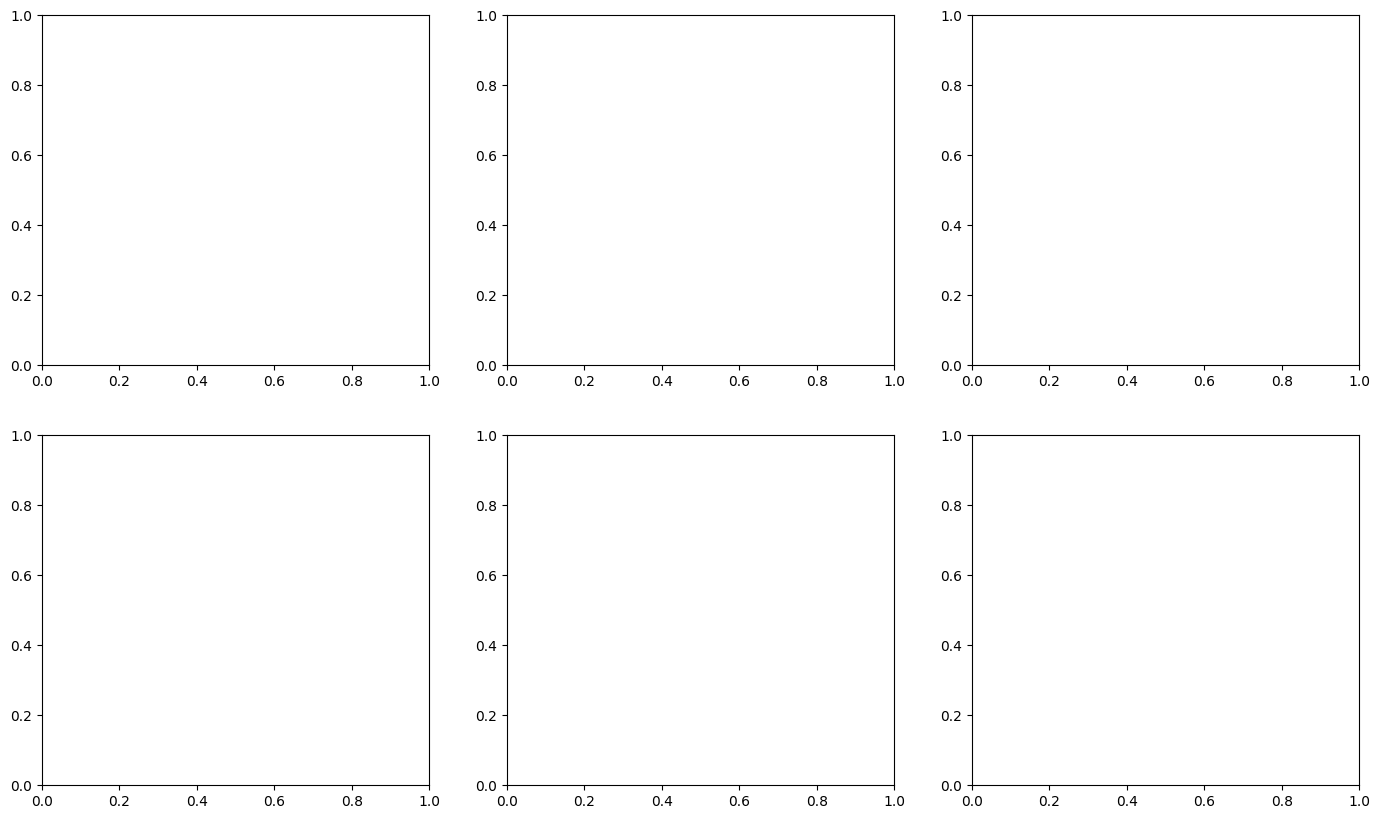

In [2]:
from memory_exp import HistogramDatasetSampleBackward, HistogramDatasetSampleForward, HistogramDatasetSampleBackwardWithBOS
from data_import import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from memory_exp import *
import matplotlib as mpl

bright_distinguishable_colors = plt.cm.tab20.colors
bright_distinguishable_colors = {d: c for c, d in zip(bright_distinguishable_colors,df_orig.model_dim.unique())}

fig, axes = plt.subplots(2,3,figsize=(17,10))
model_config = MODELS['dot+sftm']
k = df_orig
d = 64
a = k[(k.attention_input == model_config['attention_input'])
            & (k.no_softmax == model_config['no_softmax']) 
            & (k.dataset_type == model_config['dataset'])
            & (k.model_dim == d)]
print(a)
ps = [16,32,128]
ax_idx_d = {d: i for i, d in enumerate(ps)}
for p, g in a.reset_index().groupby('p'):
    print(p,ps)
    if p not in ps:
        continue
    idx = ax_idx_d[p]
    # find the row with the highest validation accuracy
    g = g.set_index('name').sort_values('val_acc',ascending=True)
    config = g.iloc[0]
    model, word_embeddings = load_model(config)
    dataset_cls = {'forward': HistogramDatasetSampleForward,
                    'backward': HistogramDatasetSampleBackward,
                    'backward_BOS': HistogramDatasetSampleBackwardWithBOS}[config['dataset_type']]
    val_dataset = dataset_cls(config['seq_len'], config['T'], int(0.3 * config['num_samples']))
    train_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    criterion = nn.CrossEntropyLoss()
    n_classes = config['seq_len']+1
    activ = []
    ys = []
    outputs = []
    attn_probs = []
    mixeds = []
    Xs = []
    preds = []
    acc = 0
    val_loss = 0
    counter = word_embeddings.sum(axis=0)/T
    for X, y in train_dataloader:
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        
        # compute accuracy
        pred = output.argmax(axis=-1)
        preds.append(pred.detach().cpu().numpy())
        ys.append(y.detach().cpu().numpy())
        Xs.append(X.detach().cpu().numpy())

    preds = np.concatenate(preds).flatten()
    ys = np.concatenate(ys).flatten()
    
    confusion = np.zeros((config['seq_len']+1,config['seq_len']+1))
    for i in range(len(ys)):
        confusion[ys[i],preds[i]] += 1

    im = axes[0,idx].imshow(confusion/confusion.sum(), origin='lower', cmap='binary',norm=mpl.colors.LogNorm())
    
    axes[0,idx].set_xlabel('prediction')
    axes[0,idx].set_ylabel('ground truth')
    axes[0,idx].set_xlim(0.5,config['seq_len']-0.5)
    axes[0,idx].set_ylim(0.5,config['seq_len']-0.5)
    axes[0,idx].set_xticks(range(1, config['seq_len']))
    
    
    
    word_embeddings = word_embeddings #/ torch.norm(word_embeddings,dim=-1).unsqueeze(-1)
    outer = word_embeddings @ word_embeddings.T

    outer = outer.flatten()
    mask = (np.eye(word_embeddings.shape[0]) == 0).flatten()
    axes[1,idx].hist(outer[mask].detach().numpy().flatten(),bins=100,histtype='step',color='tab:orange',density=True)
    axes[1,idx].hist(outer[~mask].detach().numpy().flatten(),bins=30,histtype='step',color='tab:blue',density=True)
    axes[1,idx].axvline(outer[mask].median().item(),color='tab:orange')
    axes[1,idx].axvline(outer[~mask].median().item(),color='tab:blue')
    axes[1,idx].set_ylabel('overlap')
    axes[1,idx].set_xlabel('density')
    
    axes[0,idx].text(1, 9, f'${config["val_acc"]:.2f}\%$ accuracy')
    axes[0,idx].set_title(f'$p={p}$')
    
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cax = axes[0,-1].inset_axes([0.75,0.05,0.04,0.4])


# Add a colorbar to the inset_axes
cbar = plt.colorbar(im, cax=cax, label='density')
axes[1,0].plot([],[],label=r'same - $\langle e_t, e_t \rangle$',color='tab:orange')
axes[1,0].plot([],[],label=r'different - $\langle e_t, e_s \rangle$',color='tab:blue')
axes[1,0].legend()
plt.savefig(figure_dir / 'changing-p-for-fixed-d-dotsftm.pdf',bbox_inches='tight')